In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [            
            [ 178.478431, -17.6426563 ], 
            [ 178.4875358, -17.6427653 ], 
            [ 178.5163223, -17.6076001 ], 
            [ 178.5020381, -17.6065642 ], 
            [ 178.478431, -17.6426563 ],
        ]
    ],
}

In [3]:
time_of_interest = "2019-06-01/2021-08-01"

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 9 Items


In [5]:
least_cloudy_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

Choosing S2B_MSIL2A_20210707T221939_R029_T60KXF_20210708T142045 from 2021-07-07 with 0.502776% cloud cover


In [6]:
asset_href = least_cloudy_item.assets["visual"].href
signed_href = pc.sign(asset_href)

In [7]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

with rasterio.open(signed_href) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

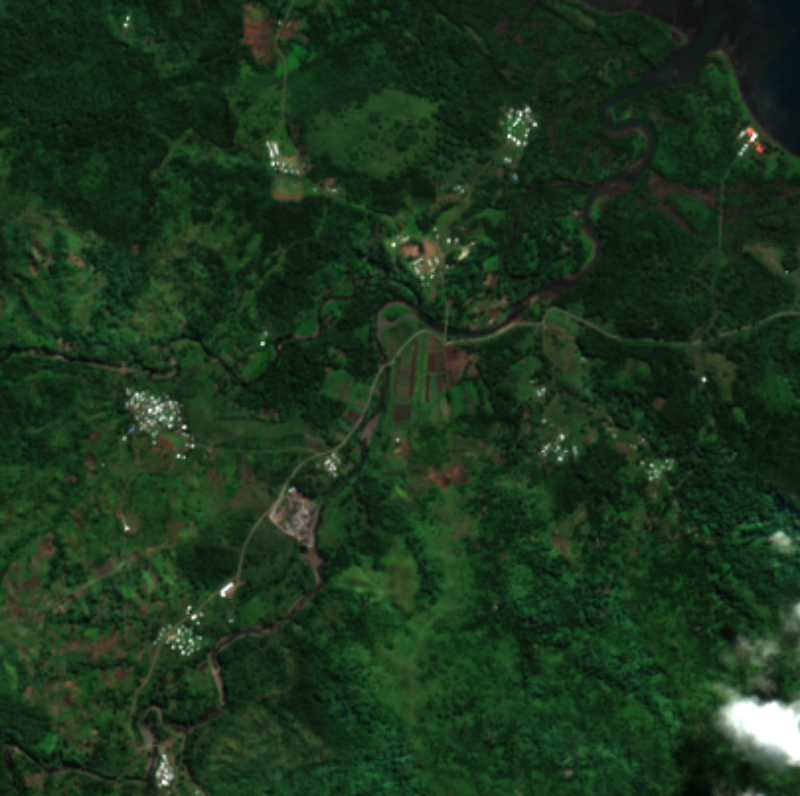

In [8]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.BILINEAR)
